In [1]:
import itertools
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import analysis_dir
from storage import get_storage_functions

# Set parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# input fields
#============================================================================
rfmap_analysis = 'feat_corr_map'  # 'model_perf_map' or 'feat_corr_map'
rfmap_dset     = 'corr'
est_kind       = 'opt'            # for rf fit, 'opt' or 'mle'


#============================================================================
# preprocessing
#============================================================================
z_thres          = 1     # if not None, clip all values below this z-score
square_transform = True  # square map values (positive values) before fitting


#============================================================================
# cross-validation
#============================================================================
# whether to use across-split maps vs. per-split ones
across_splits = False

# exclude_diag = True:
#   only makes sense if across_splits = True
#   RF maps underlying gaussian fits are the same as those for testing
#   will only compare different splits (off-diagonal pairs, 2 * n-choose-2)
# exclude_diag = False:
#   either maps underlying gaussian fits are different from those for testing
#   (e.g., zeroth fix vs. non-zeroth fix), or to evaluate fit goodness
#   will compare all split pairs (n-squared)
exclude_diag = True


#============================================================================
# paths
#============================================================================
rfmap_dir  = None
rffit_dir  = None
output_dir = None

In [3]:
# Parameters
sess_name = "Pa210201"
rfmap_analysis = "feat_corr_map"
rfmap_dir = "../test_results"
rffit_dir = "../test_results"
output_dir = "../test_results"


# Check prereqs and params

In [4]:
if rfmap_dir is None:
    rfmap_dir  = analysis_dir + rfmap_analysis
if rffit_dir is None:
    rffit_dir = rfmap_dir + '-rf_fit'
if output_dir is None:
    output_dir = rfmap_dir + '-rf_cons'

rfmap_path = Path(rfmap_dir) / (sess_name + '.h5')
print('Loading RF maps from', rfmap_path)
rfmap_path = rfmap_path.expanduser()
assert rfmap_path.is_file()

rffit_path = Path(rffit_dir) / (sess_name + '.h5')
print('Loading RF Gaussian fit from', rffit_path)
rffit_path = rffit_path.expanduser()
assert rffit_path.is_file()

output_dir = Path(output_dir)
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()
assert output_path.parent.is_dir()

Loading RF maps from ../test_results/Pa210201.h5
Loading RF Gaussian fit from ../test_results/Pa210201.h5
Saving results to ../test_results/Pa210201.h5


In [5]:
with h5.File(rfmap_path, 'r') as f:
    assert f[f'progress_report/{rfmap_analysis}/all_done'][()].item()

with h5.File(rffit_path, 'r') as f:
    assert f[f'progress_report/rf_fit/all_done'][()].item()

In [6]:
analysis_name = 'rf_cons'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
if exclude_diag:
    assert not across_splits, 'cannot exclude diagonal when using across-split maps'

In [9]:
group = analysis_name + '/config/'

save_results(group+'rfmap_analysis', rfmap_analysis)
save_results(group+'rfmap_dset', rfmap_dset)
save_results(group+'z_thres', np.nan if z_thres is None else z_thres)
save_results(group+'square_transform', square_transform)
save_results(group+'exclude_diag', exclude_diag)
save_results(group+'across_splits', across_splits)

with h5.File(rfmap_path, 'r') as f:
    loc = rfmap_analysis + '/unit_names'
    unit_names = f[loc][()].astype(str)
    if rfmap_path != output_path:  # else is using same file for I/O
        copy_group(f, loc, analysis_name+'/unit_names')

# Load and preprocess RF maps

In [10]:
rf_ds = xr.load_dataset(rfmap_path, group=f'{rfmap_analysis}/data', engine='h5netcdf')
rf_xlocs = rf_ds['rf_x'].values
rf_ylocs = rf_ds['rf_y'].values

if across_splits:
    rf_ds = rf_ds[rfmap_dset]
    assert 'split' not in rf_ds.coords
    rf_ds = rf_ds.expand_dims(dim=dict(split=[-1]))
else:
    rf_ds = rf_ds[rfmap_dset+'_per_split']
    assert 'split' in rf_ds.coords

# temporarily reshape values for analysis
dims_ = ('unit', 'rf_x', 'rf_y')
temp_dims = ('split', *(d for d in rf_ds.dims if d not in dims_+('split',)), *dims_)
rfs = rf_ds.transpose(*temp_dims).rename('rfs')

In [11]:
rfs_ = rfs.values
rfs_orig = rfs_.copy()  # for plotting only

# process only positive points
m = rfs_ > 0
npos = m.sum((-1,-2))

# optionally apply square transform
if square_transform:
    rfs_[~m] = 0
    rfs_[m] = np.square(rfs_[m])

if z_thres is not None:
    vals = np.moveaxis(rfs_, -3, 0)
    vals = vals.reshape(len(vals), -1)
    m = np.median(vals, -1)
    s = np.median(np.abs(vals - m[:,None]), -1)
    m_ = (rfs_ - m[:,None,None]) < z_thres * s[:,None,None]
    rfs_[m_] = 0

rfs.values[:] = rfs_

# Load Gaussian fits

In [12]:
# Gaussian fits do not have to be from the same maps as the compared ones
# e,g., one could compare between:
# 1. Gaussian fit of 0th fixation RFs
# 2. Saccade-aligned RFs
group = 'rf_fit/' + est_kind + ('/per_split', '/across_splits')[across_splits]
fits = xr.load_dataset(rffit_path, group=group, engine='h5netcdf')['data'].rename('rf_fits')

In [13]:
s = set(fits.dims) - set(rfs.dims) - {'feature'}
assert not s, f'extras dimensions in RF fits vs. Rfs: {s}'

for d in fits.dims:
    if d == 'feature': continue
    assert np.array_equal(np.unique(fits.coords[d]), np.unique(rfs.coords[d])), \
        f'dimension "{d}" does not match between RF fits and RFs'

# Main

In [14]:
nx = rf_xlocs.size
ny = rf_ylocs.size
xys_ = np.array(np.meshgrid(rf_xlocs, rf_ylocs)).reshape(2,-1).T  # shape (n=nx*ny, 2)

def get_gauss2d(mux, muy, xvar_inv, yvar_inv, t):
    e1x = np.cos(t)
    e1y = np.sin(t)
    U = np.array([[e1x, -e1y], [e1y, e1x]])
    Lam_inv = np.diag([xvar_inv, yvar_inv])
    Sig_inv = U @ Lam_inv @ U.T
    mu = np.array([[mux, muy]])
    def gauss2d(xys):
        # xys: shape (n, 2)
        dxys = (xys - mu)
        return np.exp(-0.5 * dxys[:,None,:] @ Sig_inv @ dxys[:,:,None]).ravel()
    return gauss2d

In [15]:
def pearsonr(a, b):
    try:
        if (not a.size) or np.isclose(a.var(), 0) or np.isclose(b.var(), 0):
            return np.nan
        return np.clip(np.corrcoef(a, b)[0, 1], -1, 1)
    except:
        return np.nan

In [16]:
ncomb = rfs['split'].size * (fits['split'].size - int(exclude_diag))
combs = tuple(
    (i, j)
    for j in range(rfs['split'].size)
    for i in range(fits['split'].size)
    if i != j or not exclude_diag)
assert len(combs) == ncomb

assert temp_dims[0] == 'split' and temp_dims[-2:] == ('rf_x', 'rf_y')  # sanity check
cond_dims = temp_dims[1:-2]
cond_shape = tuple(rfs[d].size for d in cond_dims)
ncond = np.prod(cond_shape)
cond_iter = itertools.product(*(range(rfs[d].size) for d in cond_dims))
corr = np.full((ncomb, ncond), np.nan, dtype=np.float32)
wavg = np.full_like(corr, np.nan)

icond_dims_in_fit = tuple((i, d) for i,d in enumerate(temp_dims[1:-2]) if d in fits.dims)

for icond, cond in enumerate(tqdm(cond_iter, total=ncond)):
    isp_fit0 = -1
    for icomb, (isp_fit, isp_rf) in enumerate(combs):
        if isp_fit != isp_fit0:
            isp_fit0 = isp_fit
            idx = {d: cond[i] for i, d in icond_dims_in_fit}
            idx['split'] = isp_fit
            feats = fits[idx]
            mu = feats.sel(feature=['x','y']).values
            ell = feats.sel(feature=['a','b','ang_rad'])
            if np.isfinite(mu).all() and np.isfinite(ell).all() and (ell[:2] > 0).all():
                xstd, ystd, t = ell
                xvar_inv = 1/np.square(xstd)
                yvar_inv = 1/np.square(ystd)
                fit_ = get_gauss2d(*mu, xvar_inv, yvar_inv, t)(xys_).reshape(ny, nx)
            else:
                continue

        idx = {d: i for d, i in zip(cond_dims, cond)}
        idx['split'] = isp_rf
        rf_ = rfs[idx].transpose('rf_y', 'rf_x').values
        corr[icomb, icond] = pearsonr(rf_.ravel(), fit_.ravel())
        wavg[icomb, icond] = (rf_.ravel() * fit_.ravel()).sum() / fit_.sum()

corr = corr.reshape(ncomb, *cond_shape)
wavg = wavg.reshape(ncomb, *cond_shape)

100%|██████████████████████████████████████▊| 6417/6448 [05:42<00:01, 19.35it/s]

100%|██████████████████████████████████████▊| 6419/6448 [05:42<00:01, 18.53it/s]

100%|██████████████████████████████████████▊| 6421/6448 [05:42<00:01, 18.68it/s]

100%|██████████████████████████████████████▊| 6423/6448 [05:42<00:01, 18.77it/s]

100%|██████████████████████████████████████▊| 6425/6448 [05:42<00:01, 18.86it/s]

100%|██████████████████████████████████████▊| 6427/6448 [05:42<00:01, 18.95it/s]

100%|██████████████████████████████████████▉| 6429/6448 [05:42<00:01, 18.98it/s]

100%|██████████████████████████████████████▉| 6431/6448 [05:42<00:00, 17.72it/s]

100%|██████████████████████████████████████▉| 6433/6448 [05:42<00:00, 18.06it/s]

100%|██████████████████████████████████████▉| 6435/6448 [05:43<00:00, 16.88it/s]

100%|██████████████████████████████████████▉| 6437/6448 [05:43<00:00, 17.47it/s]

100%|██████████████████████████████████████▉| 6439/6448 [05:43<00:00, 17.93it/s]

100%|██████████████████████████████████████▉| 6441/6448 [05:43<00:00, 17.41it/s]

100%|██████████████████████████████████████▉| 6444/6448 [05:43<00:00, 18.71it/s]

100%|██████████████████████████████████████▉| 6446/6448 [05:43<00:00, 18.73it/s]

100%|███████████████████████████████████████| 6448/6448 [05:43<00:00, 18.84it/s]

100%|███████████████████████████████████████| 6448/6448 [05:43<00:00, 18.76it/s]

In [17]:
dims = ('cv_pair',) + cond_dims
coords = {d: rfs.coords[d].values for d in cond_dims}
coords['cv_pair'] = [','.join(map(str,v)) for v in combs]  # xr plays poorly with 2d info in 1 dim
data_vars = {
    'corr': (dims, corr),
    'wavg': (dims, wavg)}
ds = xr.Dataset(data_vars, coords=coords)

compr = dict(zlib=True, complevel=9)
encoding = {
    k: dict(chunksizes=v.shape, **compr)
    for k, v in ds.data_vars.items()}
ds.to_netcdf(
    output_path, group=analysis_name+'/data',
    mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [18]:
save_results(f'progress_report/{analysis_name}/all_done', True, overwrite=True)

In [19]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-19T20:43:04.218532-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

numpy : 1.24.3
xarray: 2023.4.2
h5py  : 3.8.0
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]



# Basic visualization of results

In [20]:
import matplotlib.pyplot as plt

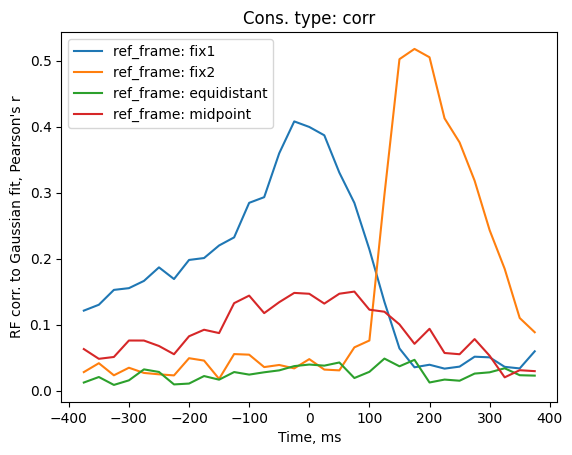

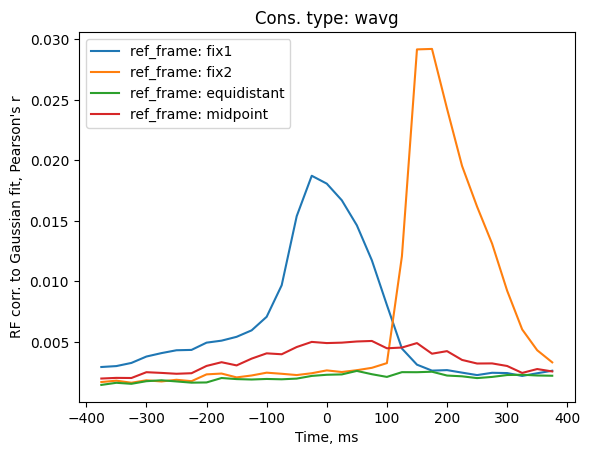

In [21]:
for cons_type, cons in zip(('corr', 'wavg'), (corr, wavg)):
    plt.figure()

    cons = xr.DataArray(cons, coords={k:rfs.coords[k] for k in cond_dims}, dims=('comb',)+cond_dims)
    cons.values[~np.isfinite(cons)] = np.nan
    m = cons.mean(['comb','unit'])
    dims_ = tuple(d for d in m.dims if d != 'time')
    cond_iter = itertools.product(*(range(m[d].size) for d in dims_))

    ls = []
    vs = []
    for cond in cond_iter:
        l = ', '.join(f'{d}: {m.coords[d][i].item()}' for i, d in zip(cond, dims_))
        m_ = m[{d: i for i, d in zip(cond, dims_)}]
        if 'time' in cons.dims:
            plt.plot(m['time'], m_, label=l)
        else:
            ls.append(l)
            vs.append(m_)

    if 'time' in cons.dims:
        plt.legend()
        plt.xlabel('Time, ms')
    else:
        n = len(vs)
        plt.scatter(range(n), vs)
        plt.xticks(range(n), ls, rotation=90)

    plt.title(f'Cons. type: {cons_type}')
    plt.ylabel('RF corr. to Gaussian fit, Pearson\'s r')